# Modeling

In [1]:
import pandas as pd
import sklearn

In [2]:
file_path = './out/prepared_dataset.csv'
df = pd.read_csv(file_path, delimiter=',', index_col=0)

# Controllo delle prime righe del dataset per visualizzare i dati
df.head()

,rating,games_minutes,offsides,shots_total,shots_on,goals_total,goals_conceded,goals_assists,goals_saves,passes_total,...,penalty_committed,penalty_scored,penalty_missed,penalty_saved,rating_target,position_Defender,position_Goalkeeper,position_Midfielder,result_status_encoded,games_substitute_encoded
1,0.666667,-0.379310,0.0,2.0,2.0,0.0,0.0,0.0,0.0,-0.142857,...,0.0,0.0,0.0,0.0,-0.5,0,0,1,1,0
2,0.000000,0.224138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.750000,...,0.0,0.0,0.0,0.0,0.5,1,0,0,1,0
3,0.500000,0.224138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.285714,...,0.0,0.0,0.0,0.0,0.5,1,0,0,2,0
4,1.000000,-0.275862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.857143,...,0.0,0.0,0.0,0.0,0.5,1,0,0,2,0
6,0.166667,0.086207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.321429,...,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0


### Train and test split

In [3]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['rating_target'])  # Caratteristiche
y = df['rating_target']  # Target

# Suddivisione in training e test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Random Forest

###  K-Fold Cross Validation

In [4]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor

# Random Forest
model = RandomForestRegressor(random_state=42)
kf = KFold(n_splits=5)

# Calcolo delle score
scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
print("Mean Squared Error:", -scores.mean())

Mean Squared Error: 0.6753732054089929


### Training e valutazione

In [5]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 0.9323529220779222
R^2 Score: 0.7254117537120844


### Ottimizzazione degli Iperparametri

In [6]:
from sklearn.model_selection import GridSearchCV

# Esempio di Grid Search per Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", -grid_search.best_score_)

Best parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.6604147772943106


### Test del modello

In [7]:
from sklearn.metrics import root_mean_squared_error

best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)
best_predictions = best_model.predict(X_test)

best_mse = mean_squared_error(y_test, best_predictions)
best_r2 = r2_score(y_test, best_predictions)
best_rmse = root_mean_squared_error(y_test, best_predictions)

print("Mean Squared Error (best model):", best_mse)
print("R^2 Score (best model):", best_r2)
print("RMSE Score (best model):", best_rmse)

Mean Squared Error (best model): 0.9300153218370488
R^2 Score (best model): 0.7261002028341541
RMSE Score (best model): 0.9643730200690233


## XGBoost

### training

In [8]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Crea un oggetto DMatrix per XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Imposta i parametri per XGBoost
params = {
    'objective': 'reg:squarederror',  # Obiettivo di regressione
    'max_depth': 5,                   # Profondità massima dell'albero
    'eta': 0.1,                       # Tasso di apprendimento
    'eval_metric': 'rmse'             # Metodologia di valutazione
}

# Addestra il modello
model_xgb = xgb.train(params, dtrain, num_boost_round=100)

### test

In [9]:
# Previsioni sul set di test
y_pred_xgb = model_xgb.predict(dtest)

# Calcola l'RMSE
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
print(f'XGBoost RMSE: {rmse_xgb}')

XGBoost RMSE: 0.979104663657832


c:\Users\Operator\.conda\envs\general\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [10]:
from sklearn.model_selection import GridSearchCV

# Parametri da cercare
param_grid = {
    'max_depth': [3, 5, 7],
    'eta': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 200]
}

# Inizializza il modello XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Configura la ricerca
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

# Esegui la ricerca
grid_search.fit(X_train, y_train)

# Risultati migliori
print("Migliori parametri:", grid_search.best_params_)

# Addestra il modello con i migliori parametri
best_xgb_model = grid_search.best_estimator_

# Previsioni con il modello ottimizzato
y_pred_best_xgb = best_xgb_model.predict(X_test)

# Calcola l'RMSE con il modello ottimizzato
rmse_best_xgb = mean_squared_error(y_test, y_pred_best_xgb, squared=False)
print(f'XGBoost con parametri ottimizzati RMSE: {rmse_best_xgb}')

Migliori parametri: {'eta': 0.1, 'max_depth': 3, 'n_estimators': 50}
XGBoost con parametri ottimizzati RMSE: 0.9481502598719759


c:\Users\Operator\.conda\envs\general\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


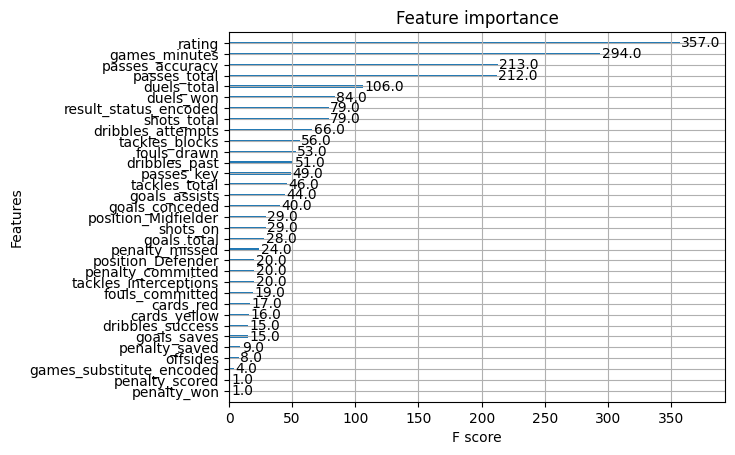

In [11]:
import matplotlib.pyplot as plt

# Plot dell'importanza delle feature
xgb.plot_importance(model_xgb)
plt.show()

## Support Vector Regression 

### Training

In [12]:
from sklearn.svm import SVR

# Creazione del modello SVR
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)  # Puoi cambiare il kernel e altri parametri

# Addestramento del modello
svr_model.fit(X_train, y_train)


SVR()

In [13]:
# Previsioni sul set di test
y_pred_svr = svr_model.predict(X_test)

# Calcola l'RMSE
rmse_svr = mean_squared_error(y_test, y_pred_svr, squared=False)
print(f'SVR RMSE: {rmse_svr}')

SVR RMSE: 1.757912062106917


c:\Users\Operator\.conda\envs\general\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [14]:
from sklearn.model_selection import GridSearchCV

# Parametri da cercare
param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.5],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

# Inizializza il modello SVR
svr = SVR()

# Configura la ricerca
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

# Esegui la ricerca
grid_search.fit(X_train, y_train)

# Risultati migliori
print("Migliori parametri:", grid_search.best_params_)

# Addestra il modello con i migliori parametri
best_svr_model = grid_search.best_estimator_

# Previsioni con il modello ottimizzato
y_pred_best_svr = best_svr_model.predict(X_test)

# Calcola l'RMSE con il modello ottimizzato
rmse_best_svr = mean_squared_error(y_test, y_pred_best_svr, squared=False)
print(f'SVR con parametri ottimizzati RMSE: {rmse_best_svr}')

Migliori parametri: {'C': 10, 'epsilon': 0.5, 'kernel': 'rbf'}
SVR con parametri ottimizzati RMSE: 1.5444495535062


c:\Users\Operator\.conda\envs\general\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## LightGBM

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import numpy as np


# Addestra il modello
lgb_model_orig = lgb.LGBMRegressor()
lgb_model_orig.fit(X_train, y_train)

# Previsioni 
y_pred = lgb_model_orig.predict(X_test)

# Calcola le metriche p
rmse_orig = np.sqrt(mean_squared_error(y_test, y_pred))
r2_orig = r2_score(y_test, y_pred)


# Stampa i risultati
print(f"Performance:")
print(f"RMSE: {rmse_orig:.4f}, R²: {r2_orig:.4f}")



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 403
[LightGBM] [Info] Number of data points in the train set: 1228, number of used features: 28
[LightGBM] [Info] Start training from score -0.425081
Performance:
RMSE: 1.0839, R²: 0.6540


In [16]:
from sklearn.model_selection import GridSearchCV

# Imposta i parametri da testare
param_grid = {
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [100, 200, 500]
}

# Crea il modello LightGBM
lgb_model = lgb.LGBMRegressor()

# Crea la Grid Search
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid,
                           scoring='neg_root_mean_squared_error',
                           cv=5, n_jobs=-1, verbose=2)

# Esegui la Grid Search sui dati scalati
grid_search.fit(X_train, y_train)

# Stampa i risultati migliori
print(f"Migliori parametri: {grid_search.best_params_}")
print(f"RMSE migliore: {-grid_search.best_score_:.4f}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits


c:\Users\Operator\.conda\envs\general\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 403
[LightGBM] [Info] Number of data points in the train set: 1228, number of used features: 28
[LightGBM] [Info] Start training from score -0.425081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 